# Feature Engineering

In the real world, data rarely comes in the form we would like it to. For this reason, one of the more important steps in using machine learning in practice is _feature engineering_, which consists of taking whatever information we have about a problem and turning it into numbers that we can use to build our feature matrix.

This section covers a few common examples of feature engineering tasks: features for representing _categorical data_, _text data_, and _images_. Additionally, _derived features_ for increasing model complexity and _imputation_ of missing data will be discussed as well. Often this process is known as _vectorization_, as it involves converting arbitrary data into well-behaved vectors.

## Categorical features

One common type of non-numerical data is _categorical_ data. For example, consider this data on housing prices, which includes "neighborhood" information along with numerical features like "price" and "rooms":

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

Scikit-Learn's models make the fundamental assumption that numerical features reflect algebraic quantities. Thus, a simple mapping like the one below would imply, for example, that _Queen Anne_ < _Fremont_ < _Wallingford_, which does not make much sense.

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

In such cases, one proven technique is to use _one-hot encoding_, which creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively. When the data comes as a list of dictionaries, Scikit-Learn's `DictVectorizer` can do this for us:

In [3]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

We can see that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels. 

To see the meaning of each column, we can inspect the feature names:

In [4]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

One disadvantage of this approach is that if categories have many possible values, this can _greatly_ increase the size of the dataset in memory. However, because the encoded data usually contains mostly zeros, a sparse output can be a very efficient solution:

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. Scikit-Learn includes two additional tools to support this type of encoding: `sklearn.preprocessing.OneHotEncoder` and `sklearn.feature_extraction.FeatureHasher`.

## Text Features

Another common need in feature engineering is to convert text data to a set of representative numerical values. One of the simplest methods of encoding such data is by _word counts_: we take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of phrases:

In [6]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

Scikit-Learn's `CountVectorizer` conveniently constructs such a representation for us:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears. We can convert this to a `DataFrame` to inspect the result:

In [8]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


One issue of this approach is that the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal, especially when considering _stop words_. One approach to fix this is known as _term frequency-inverse document frequency_ (TF-IDF) which weights the word counts by a measure of how often they appear in the corpus. The syntax for computing these features is similar to the previous example:

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Image Features

Another common need is to suitably encode images for machine learning analysis. The simplest approach is to use the pixel values themselves. But depending on the application, such a approach may not be optimal. The [Scikit-Image project](http://scikit-image.org/) offers excellent implementations of many of the standard approaches.

## Derived Features

Another useful type of feature is one that is mathematically derived from some input features. In the previous section we saw that we could convert a liner regression into a polynomial regression by transforming the input. This is sometimes known as _basis function regression_.

For example, this data cannot be well described by a straight line:

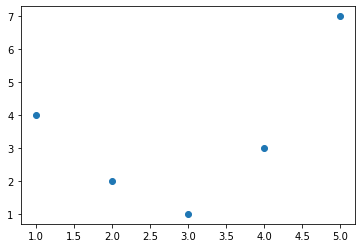

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);

Still, we can fit a line to the data using `LinearRegression`:

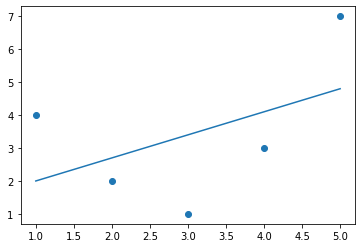

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

However, it's pretty clear that we need a more sophisticated model to describe the relationship between $x$ and $y$.

One approach would be to transform the data, adding extra columns of features to drive more flexibility in the model. For example, we can add polynomial features to the data this way:

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


The derived feature matrix has columns representing $x, x^2$ and $x^3$. Computing a linear regression to this expanded input gives a much closer fit to the data:

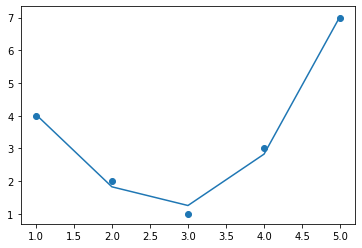

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit);

This idea of improving a model by transforming the inputs is fundamental to many of the more powerful machine learning. More generally, this is one motivational path to the powerful set of techniques known as _kernel methods_.

## Imputation of Missing Data

Yet another common need in feature engineering is the handling of missing data. For example, consider this dataset:

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

Before applying a typical machine learning model to such data, we need to replace the missing data with some appropriate fill value. This is known as _imputation_ of missing values, and has several approaches with different levels of complexity.

The sophisticated approaches tend to be very application-specific, and we won't dive into them here. For a baseline imputation approach (using the mean, median, most frequent value, or an arbitrary constant), Scikit-Learn provides the `SimpleImputer` class:

In [15]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

Now that the two missing values have been replaced with the mean of the remaining values in the column, this imputed data can be fed into a estimator:

In [16]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## Feature Pipelines

It can quickly become tedious to apply these transformations by hand, especially if we with to string together multiple steps. For example, we might want a processing pipeline that looks something like this:

1. Impute missing values using the mean
2. Transform features to quadratic
3. Fit a liner regression

Scikit-Learn provides a `Pipeline` object to streamline this type of processing pipeline. We can use it as follows:

In [17]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                     PolynomialFeatures(degree=2),
                     LinearRegression())

This pipeline looks and acts just like a standard Scikit-Learn object, and will apply all the specified steps to any input data:

In [18]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


All the steps of the model are applied automatically. Notice that for the sake of this demonstration, the model as applied to the same data it was trained on.